# Tutorial of Back-propagation Neural Network (BPNN)

    Contributed by Kai-bin QIU, Zhanghua FU, Meng QIU, Lian-xin LI and Jia-ming XIN.
                                                                        2019-09-09

### Architecture of BPNN
This notebook is tutorial for Back-propagation Neural Network (BPNN) based on the deep learning framework, Tensorflow and at the same time, it is used to recognize handwritten digits, such as 1, 2, 3 and so on. By the way, our BPNN's architecture is simple but effective. 

    The changing dimensions of data flow:
  
  $$
  \begin{equation}
  \mathcal{R}^{784} \underbrace{\to \mathcal{R}^{128} \to \mathcal{R}^{64} \to \mathcal{R}^{10}}_{\textbf{BPNN}} \to \mathcal{R}^{1}
  \end{equation}$$
    
![title](BPNN.png) 

    Cross entropy loss function: 
  $$
  \begin{equation}
  L = \frac{1}{N} \sum_{N}^{i=1} \textbf{y}_{i}^{t} * \log (\textbf{y}_{i}^{*} + epsilon)
  \end{equation}
  $$
  
$$\textbf{y}_{i}^{t} \text{is the ground truth}, \textbf{y}_{i}^{*}\text{ is the prediction label.}$$ 

### Import related modules

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4'
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from scipy.interpolate import spline

import tqdm
from tqdm import trange, tqdm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}


###  Mnist-handwritten-digit data 

    Next, loading mnist data and plotting some representative figures.

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


/work/dependence/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


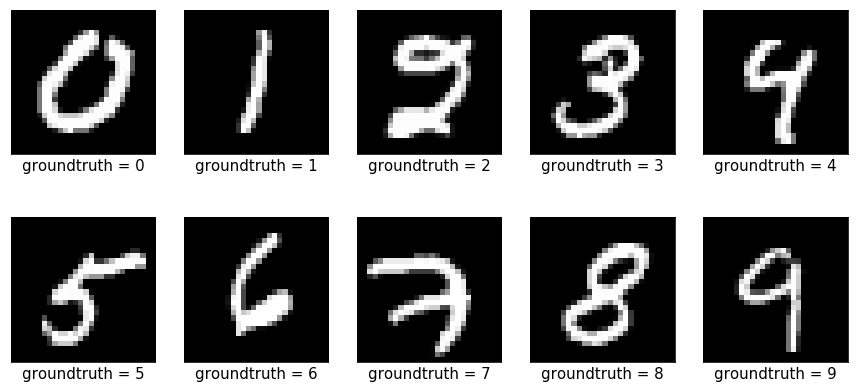

In [4]:
images = mnist.train.images
labels = mnist.train.labels
length, _ = images.shape
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2,5,i+1)
    label = np.where(labels[:,i] == 1)[0][0]
    img = np.reshape(images[label], (28, 28))
    plt.imshow(img, 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('groundtruth = {}'.format(i), fontdict = font1)
plt.show()

### t-SNE
    T-Distributed Stochastic Neighbouring Entities (t-SNE), which is aimed to reduce dimensions of input data and visualizes in 2-dimension space. 

In [5]:
test_x = mnist.test.images
train_x = images
test_y = mnist.test.labels
train_y = labels 

In [36]:
X = np.concatenate((train_x, test_x), axis=0)
y = np.argmax(np.concatenate((train_y, test_y), axis=0), 1)

In [37]:
import pandas as pd
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

In [38]:
np.random.seed(42)
# rndperm = np.random.permutation(df.shape[0])
# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df[feat_cols].values)


In [39]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 65000 samples in 0.213s...
[t-SNE] Computed neighbors for 65000 samples in 591.858s...
[t-SNE] Computed conditional probabilities for sample 1000 / 65000
[t-SNE] Computed conditional probabilities for sample 2000 / 65000
[t-SNE] Computed conditional probabilities for sample 3000 / 65000
[t-SNE] Computed conditional probabilities for sample 4000 / 65000
[t-SNE] Computed conditional probabilities for sample 5000 / 65000
[t-SNE] Computed conditional probabilities for sample 6000 / 65000
[t-SNE] Computed conditional probabilities for sample 7000 / 65000
[t-SNE] Computed conditional probabilities for sample 8000 / 65000
[t-SNE] Computed conditional probabilities for sample 9000 / 65000
[t-SNE] Computed conditional probabilities for sample 10000 / 65000
[t-SNE] Computed conditional probabilities for sample 11000 / 65000
[t-SNE] Computed conditional probabilities for sample 12000 / 65000
[t-SNE] Computed conditional probabilities for 

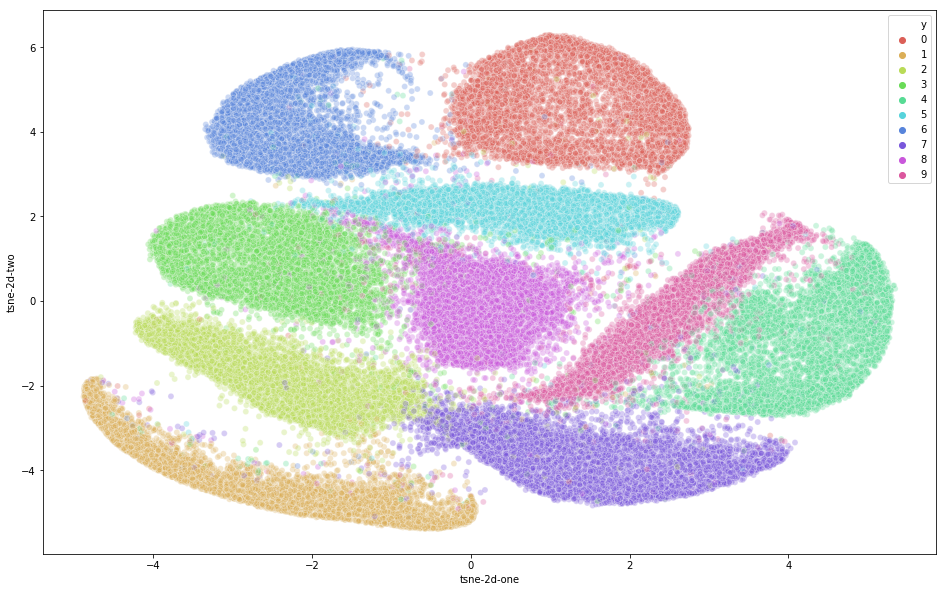

In [40]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

### Architecture for MLP


In [3]:
def mlp(input, hidden_size, variable_scope, training):

    with tf.variable_scope(variable_scope, reuse = tf.AUTO_REUSE):
        
        for i, size in enumerate(hidden_size[:-1]):
            # mlp
            if i == 0:
                output = tf.layers.dense(input, size, name = variable_scope+"_layer_{}".format(i))
            else:
                output = tf.layers.dense(output, size, name = variable_scope+"_layer_{}".format(i))
            output = tf.layers.batch_normalization(output, training=training, momentum=0.9)
            # activate function
#             output = tf.nn.sigmoid(output + 1e-6)
            output = tf.nn.relu(output)
        output = tf.layers.dense(
            output, hidden_size[-1], name = variable_scope+"_layer_{}".format(i+2))
        output = tf.nn.softmax(output)
        
    return output

Default config:
 1. batch size = 64
 2. input size = 784
 3. hidden size = [128, 64, 10]
 4. output size = 10
 5. lr = 0.001

In [4]:
class config(object):
    
    def __init__(self,
                 batch_size = 64,
                 epoch = 1100,
                 input_size = 784,
                 lr = 0.001,
                 hidden_size = [128, 64, 10],
                 output_size = 10,
                 variable_scope = 'mlp'
                ):
        self.batch_size = batch_size
        self.input_size = input_size
        self.lr = lr
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.variable_scope = variable_scope
        self.epoch = epoch

### Training our neural network

In [5]:
tf.reset_default_graph()
!rm -r logs/*
mlp_config = config()
input_x = tf.placeholder(tf.float32, [None, 784])
gt_y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder_with_default(False, shape=(), name='training')
pre_y = mlp(input_x, mlp_config.hidden_size,
            mlp_config.variable_scope, training=training)
cross_entropy = -tf.reduce_sum(gt_y*tf.log(pre_y+1e-6))

train_step = tf.train.GradientDescentOptimizer(mlp_config.lr).minimize(cross_entropy)
test_x, train_x = mnist.test.images, mnist.train.images
test_y, train_y = mnist.test.labels, mnist.train.labels
init = tf.initialize_all_variables()
best_ac = 0
losses = []
test_acies, train_acies = [], []
with tf.Session() as sess:
    sess.run(init)
    pbar = trange(1100)
    for i in pbar:
        batch_xs, batch_ys = mnist.train.next_batch(mlp_config.batch_size)
#         mean = np.repeat(np.expand_dims(np.mean(batch_xs, 1), 1), 784, axis=1)
#         std = np.repeat(np.expand_dims(np.std(batch_xs, 1), 1), 784, axis=1)
#         batch_xs = (batch_xs - mean) / std
        _, loss = sess.run([train_step, cross_entropy], feed_dict = {training:True,
                                                                     input_x:batch_xs, gt_y:batch_ys})
        correct_prediction = tf.equal(tf.argmax(pre_y,1), tf.argmax(gt_y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #loss = sess.run([cross_entropy])
        if i%10==0:

#             mean = np.repeat(np.expand_dims(np.mean(test_x, 1), 1), 784, axis=1)
#             std = np.repeat(np.expand_dims(np.std(test_x, 1), 1), 784, axis=1)
#             test_x = (test_x - mean) / std
            testset_pre, ac = sess.run([pre_y, accuracy], feed_dict={training:False,
                                                                     input_x: test_x, gt_y: test_y})
#             tr_ac = sess.run(accuracy, feed_dict = {training:False,
#                                                    input_x: train_x, gt_y: train_y})
            if best_ac<ac:
                best_ac = ac
                
                # save the models
                saver = tf.train.Saver()
                os.mkdir('./logs/model-mlp-ite-{}-ac-{}'.format(i, ac))
                saver.save(sess, './logs/model-mlp-ite-{}-ac-{}/model-mlp'.format(i, ac))
#         pbar.set_description("loss is {}, best-accuracy is {}".format(np.around(loss,2), best_ac))
        pbar.set_description("loss is {}".format(np.around(loss,2)))
        losses += [loss]
        test_acies += [ac]
#         train_acies += [tr_ac]
print('The best testing accuracy is {}'.format(best_ac))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


loss is 9.9399995803833: 100%|██████████| 1100/1100 [05:32<00:00,  3.31it/s]   


The best testing accuracy is 0.917900025844574


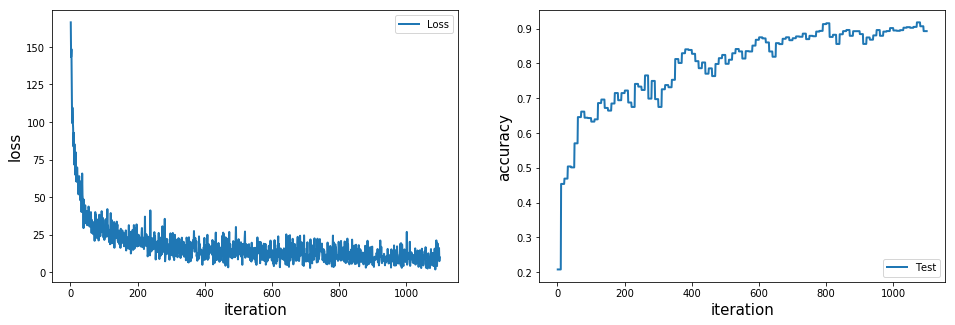

In [17]:
# T = np.arange(1, 1101)
# xnew = np.linspace(T.min(),T.max(),10000)
# losses_smooth = spline(T,losses,xnew)
# accuracies_smooth = spline(T,test_acies,xnew)

plt.figure(figsize= (16, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 1101), losses, label='loss', linewidth = 2)
plt.ylabel('loss', fontsize = 15)
plt.xlabel('iteration', fontsize = 15)
plt.legend(['Loss'], loc=1)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 1101), test_acies, label='accuracy', linewidth = 2)
# plt.plot(xnew, accuracies_smooth, label='accuracy', linewidth = 2)
# plt.plot(np.arange(1, 1101), train_acies, label='accuracy')
plt.legend(['Test'], loc=4)
plt.ylabel('accuracy', fontsize = 15)
plt.xlabel('iteration', fontsize = 15)
plt.show()

### Testing

    1. iteration = 50

In [21]:
# Testing
tf.reset_default_graph()
models_path = './logs/model-mlp-ite-50-ac-0.5702999830245972'
saver = tf.train.import_meta_graph(models_path + '/model-mlp.meta')
graph = tf.get_default_graph()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(models_path))
    input_x_ = graph.get_tensor_by_name("Placeholder:0")
    groundtruth = graph.get_tensor_by_name("Placeholder_1:0")
    training_option = graph.get_tensor_by_name("training:0")
    pre_y_ = graph.get_tensor_by_name("mlp/Softmax:0")
    #accuracy_ = graph.get_tensor_by_name("Mean_999:0")
    prediction = sess.run(pre_y_, feed_dict={training_option: False, input_x_: test_x, groundtruth: test_y})
prediction_num = np.argmax(prediction, 1)
groundtruth_num =  np.argmax(test_y, 1) 

INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-50-ac-0.5702999830245972/model-mlp


/work/dependence/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


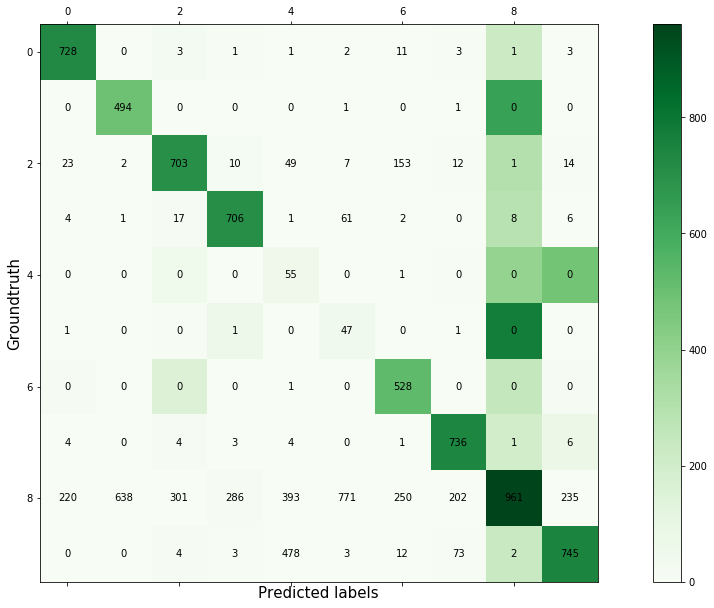

In [23]:
# Constructing the confusion matrix
cm = confusion_matrix(groundtruth_num, prediction_num)
plt.figure(figsize=(20,10))
plt.matshow(cm, cmap=plt.cm.Greens, fignum=1)
plt.colorbar()

for x in range(len(cm)):

    for y in range(len(cm)):

        plt.annotate(cm[x,y],xy=(x,y),horizontalalignment='center',verticalalignment='center')
plt.ylabel('Groundtruth', fontdict=font1)
plt.xlabel('Predicted labels', fontdict=font1)
plt.show()

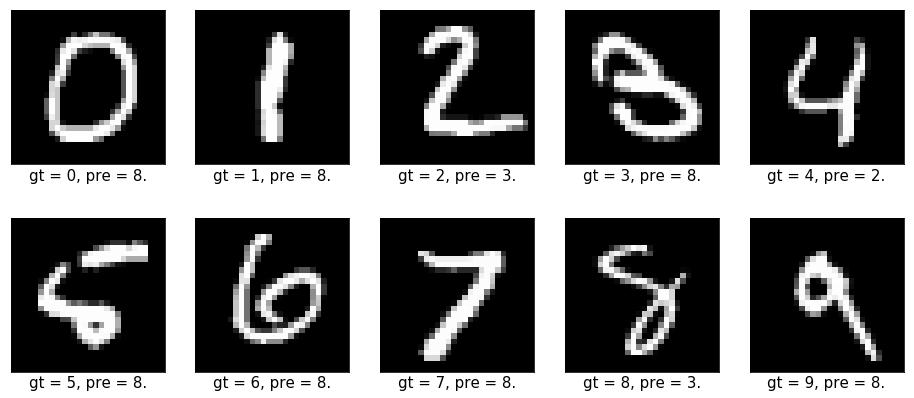

In [24]:
# Visualizing some misjudgment figures
false = np.not_equal(prediction_num, groundtruth_num)
error_images = test_x[false]
error_labels = groundtruth_num[false]
error_prediction = prediction_num[false]
plt.figure(figsize=(16,7))
plt.gray()
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if len(np.where(error_labels==i)[0]) ==0:
        
        pass
    else:
        arg = np.where(error_labels==i)[0][0]
        prediction_labels = error_prediction[arg]
        plt.imshow(np.reshape(error_images[arg], (28, 28)))
        plt.xlabel('gt = {}, pre = {}.'.format(str(i), str(prediction_labels)), fontdict=font1)

In [ ]:
# df_testset = df[55000:]
# df_false = df_testset[false]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 9),
#     data=df_false,
#     legend="full",
#     alpha=0.3
# )

    2. iteration = 1070

In [25]:
# Testing
tf.reset_default_graph()
models_path = './logs/model-mlp-ite-1070-ac-0.917900025844574'
saver = tf.train.import_meta_graph(models_path + '/model-mlp.meta')
graph = tf.get_default_graph()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(models_path))
    input_x_ = graph.get_tensor_by_name("Placeholder:0")
    groundtruth = graph.get_tensor_by_name("Placeholder_1:0")
    training_option = graph.get_tensor_by_name("training:0")
    pre_y_ = graph.get_tensor_by_name("mlp/Softmax:0")
    #accuracy_ = graph.get_tensor_by_name("Mean_999:0")
    prediction = sess.run(pre_y_, feed_dict={training_option: False, input_x_: test_x, groundtruth: test_y})
prediction_num = np.argmax(prediction, 1)
groundtruth_num =  np.argmax(test_y, 1) 

INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-1070-ac-0.917900025844574/model-mlp


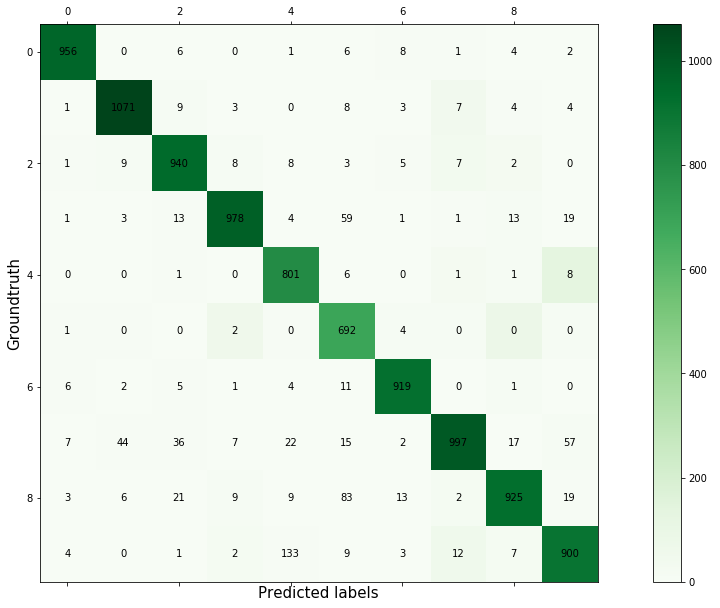

In [26]:
# Constructing a confusion matrix
cm = confusion_matrix(groundtruth_num, prediction_num)
plt.figure(figsize=(20,10))
plt.matshow(cm, cmap=plt.cm.Greens, fignum=1)
plt.colorbar()

for x in range(len(cm)):

    for y in range(len(cm)):

        plt.annotate(cm[x,y],xy=(x,y),horizontalalignment='center',verticalalignment='center')
plt.ylabel('Groundtruth', fontdict=font1)
plt.xlabel('Predicted labels', fontdict=font1)
plt.show()

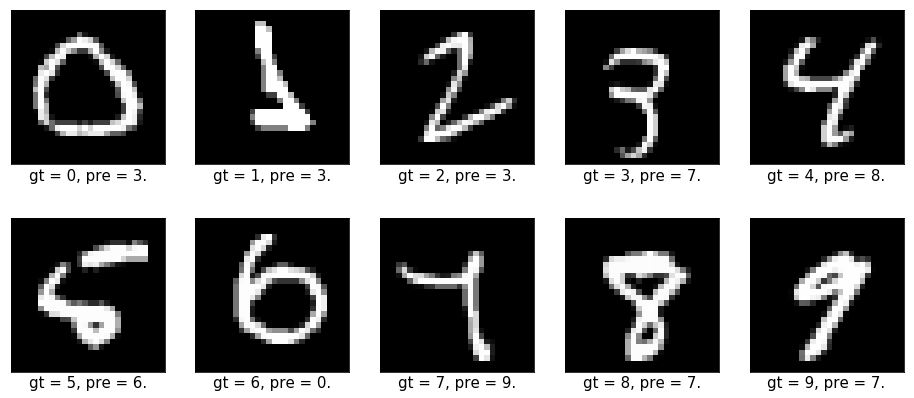

In [27]:
# Visualizing some misjudgment figures
false = np.not_equal(prediction_num, groundtruth_num)
error_images = test_x[false]
error_labels = groundtruth_num[false]
error_prediction = prediction_num[false]
plt.figure(figsize=(16,7))
plt.gray()
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    arg = np.where(error_labels==i)[0][0]
    prediction_labels = error_prediction[arg]
    plt.imshow(np.reshape(error_images[arg], (28, 28)))
    plt.xlabel('gt = {}, pre = {}.'.format(str(i), str(prediction_labels)), fontdict=font1)

In [ ]:
# df_testset = df[55000:]
# df_false = df_testset[false]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df_false,
#     legend="full",
#     alpha=0.3
# )

### Gradual changing

In [2]:
model_paths = os.listdir('./logs/')

In [19]:
test_y[3]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
# Testing
por = []
for path in model_paths:
    tf.reset_default_graph()

    models_path = './logs/{}'.format(path)
    saver = tf.train.import_meta_graph(models_path + '/model-mlp.meta')
    graph = tf.get_default_graph()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(models_path))
        input_x_ = graph.get_tensor_by_name("Placeholder:0")
        groundtruth = graph.get_tensor_by_name("Placeholder_1:0")
        training_option = graph.get_tensor_by_name("training:0")
        pre_y_ = graph.get_tensor_by_name("mlp/Softmax:0")
        #accuracy_ = graph.get_tensor_by_name("Mean_999:0")
        prediction = sess.run(pre_y_, feed_dict={training_option: False, input_x_: test_x[0:2, :],
                                                 groundtruth: test_y[0:2, :]})
    prediction_num = np.argmax(prediction, 1)
    groundtruth_num =  np.argmax(test_y, 1) 
    por.append(prediction[1, :])
#     gradual_image = test_x[raw_arg, :]
#     gradual_image = np.reshape(gradual_image, newshape=(28, 28))
    print('{} = {}, pre-label = {}'.format(path, prediction[1, 2], prediction_num[1]))

INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-0-ac-0.2079000025987625/model-mlp
model-mlp-ite-0-ac-0.2079000025987625 = 0.09627486765384674, pre-label = 9
INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-10-ac-0.4535999894142151/model-mlp
model-mlp-ite-10-ac-0.4535999894142151 = 0.09254983812570572, pre-label = 8
INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-20-ac-0.46889999508857727/model-mlp
model-mlp-ite-20-ac-0.46889999508857727 = 0.09602628648281097, pre-label = 8
INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-30-ac-0.5037999749183655/model-mlp
model-mlp-ite-30-ac-0.5037999749183655 = 0.09487693011760712, pre-label = 8
INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-50-ac-0.5702999830245972/model-mlp
model-mlp-ite-50-ac-0.5702999830245972 = 0.13275328278541565, pre-label = 3
INFO:tensorflow:Restoring parameters from ./logs/model-mlp-ite-60-ac-0.6456999778747559/model-mlp
model-mlp-ite-60-ac-0.6456999778

/work/dependence/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


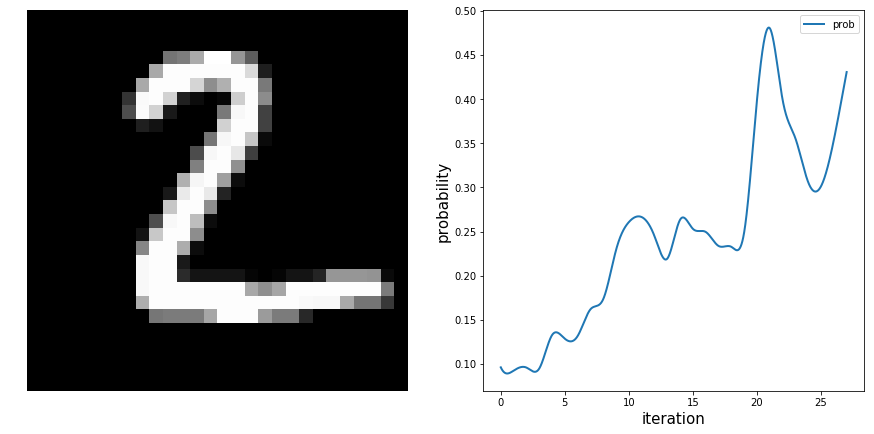

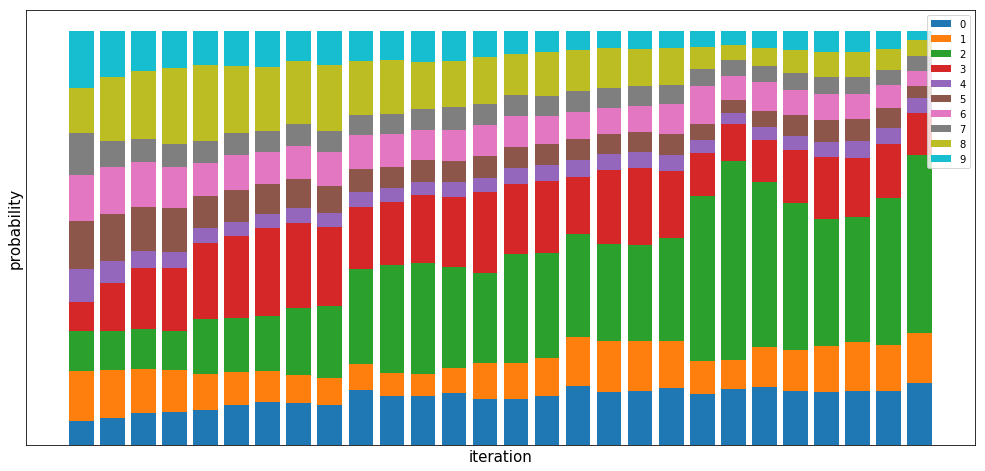

In [20]:

por = np.array(por)
length, class_num = por.shape
bar_x = np.arange(length)
benchmark = np.zeros_like(bar_x, dtype=np.float64)

xnew = np.linspace(bar_x.min(),bar_x.max(),10000)
por_smooth = spline(bar_x, por[:, 2],xnew)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
gradual_image = test_x[1, :]
gradual_image = np.reshape(gradual_image, newshape=(28, 28))
plt.imshow(gradual_image, 'gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.plot(xnew, por_smooth, linewidth = 2)
plt.xlabel('iteration', fontdict=font1)
plt.ylabel('probability', fontdict=font1)
plt.legend(['prob'])

plt.figure(figsize=(17, 8))
for i in range(class_num):
    plt.bar(bar_x, por[:, i], bottom=benchmark)
    benchmark += por[:, i]
plt.xlabel('iteration', fontdict=font1)
plt.ylabel('probability', fontdict=font1)
plt.xticks([])
plt.yticks([])
plt.legend(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), loc = 1)
plt.show()